# Defining the model

In [1]:
# only for colab
# ! pip install --upgrade albumentations

In [1]:
import torch
import importlib
from tqdm.notebook import tqdm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
!nvidia-smi

Wed Jan 19 20:43:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 497.29       Driver Version: 497.29       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0A:00.0  On |                  N/A |
|  0%   34C    P8    34W / 320W |   3997MiB / 10240MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

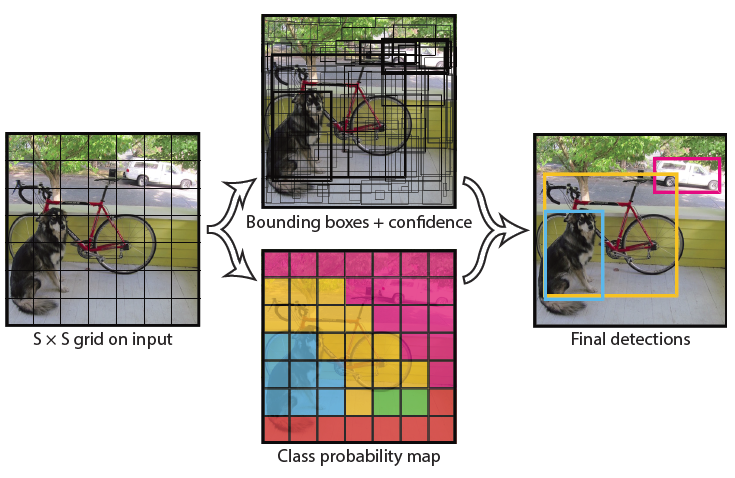

In [3]:
import dataset
import utils
import architecture
import wandb

from torch.optim import SGD
from torch.optim import Adam

### Constants

In [4]:
# from the paper
MOMENTUM = 0.9
EPOCHS = 150
DECAY = 0.0005
# model is trained with 135 epochs
# first 5 epochs from 0.001 to 0.1
# 75 epochs 0.01 epochs
# 30 epochs 0.001
# 30 epochs 0.0001
LEARNING_RATE = 0.00005
LAMBDA_NOOBJ = 0.5
LAMBDA_COORD = 5
SMOOTH = 1e-6

In [5]:
config = dict(
    # TRAINING PARAMS AND HYPERPARAMS
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    optimizer="Adam",
    momentum=MOMENTUM, # only needed for SGD
    # MODEL
    model_predefined=False,
    checkpoint=None, # only needed if model_predefined=True
    # DATASET PARAMS AND HYPERPARAMS
    batch_size=32,
    train_years=[2007, 2012],
    batch_norm=True,
    include_difficult=False,
    transforms=False,
    is_one_batch=False,
    # OTHER PARAMS TO SET
    fc_dropout=0.0, # set value of dropout in fully connected layer for overfitting, 0 means no dropout
    grid_size=7, # in paper this is S
    bounding_boxes=2, # in paper this is B
    classes=20 # in paper this is C
)

Using downloaded and verified file: ./data\VOCtrainval_06-Nov-2007.tar
Extracting ./data\VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data\VOCtest_06-Nov-2007.tar
Extracting ./data\VOCtest_06-Nov-2007.tar to ./data
Feature batch shape for training: torch.Size([32, 3, 448, 448])
Objects batch shape for training: 32
Labels matrix batch shape for training: torch.Size([32, 7, 7, 25])
Size of training set: 16576
Size of test set: 4960
Sample batch for training dataloader is presented below:


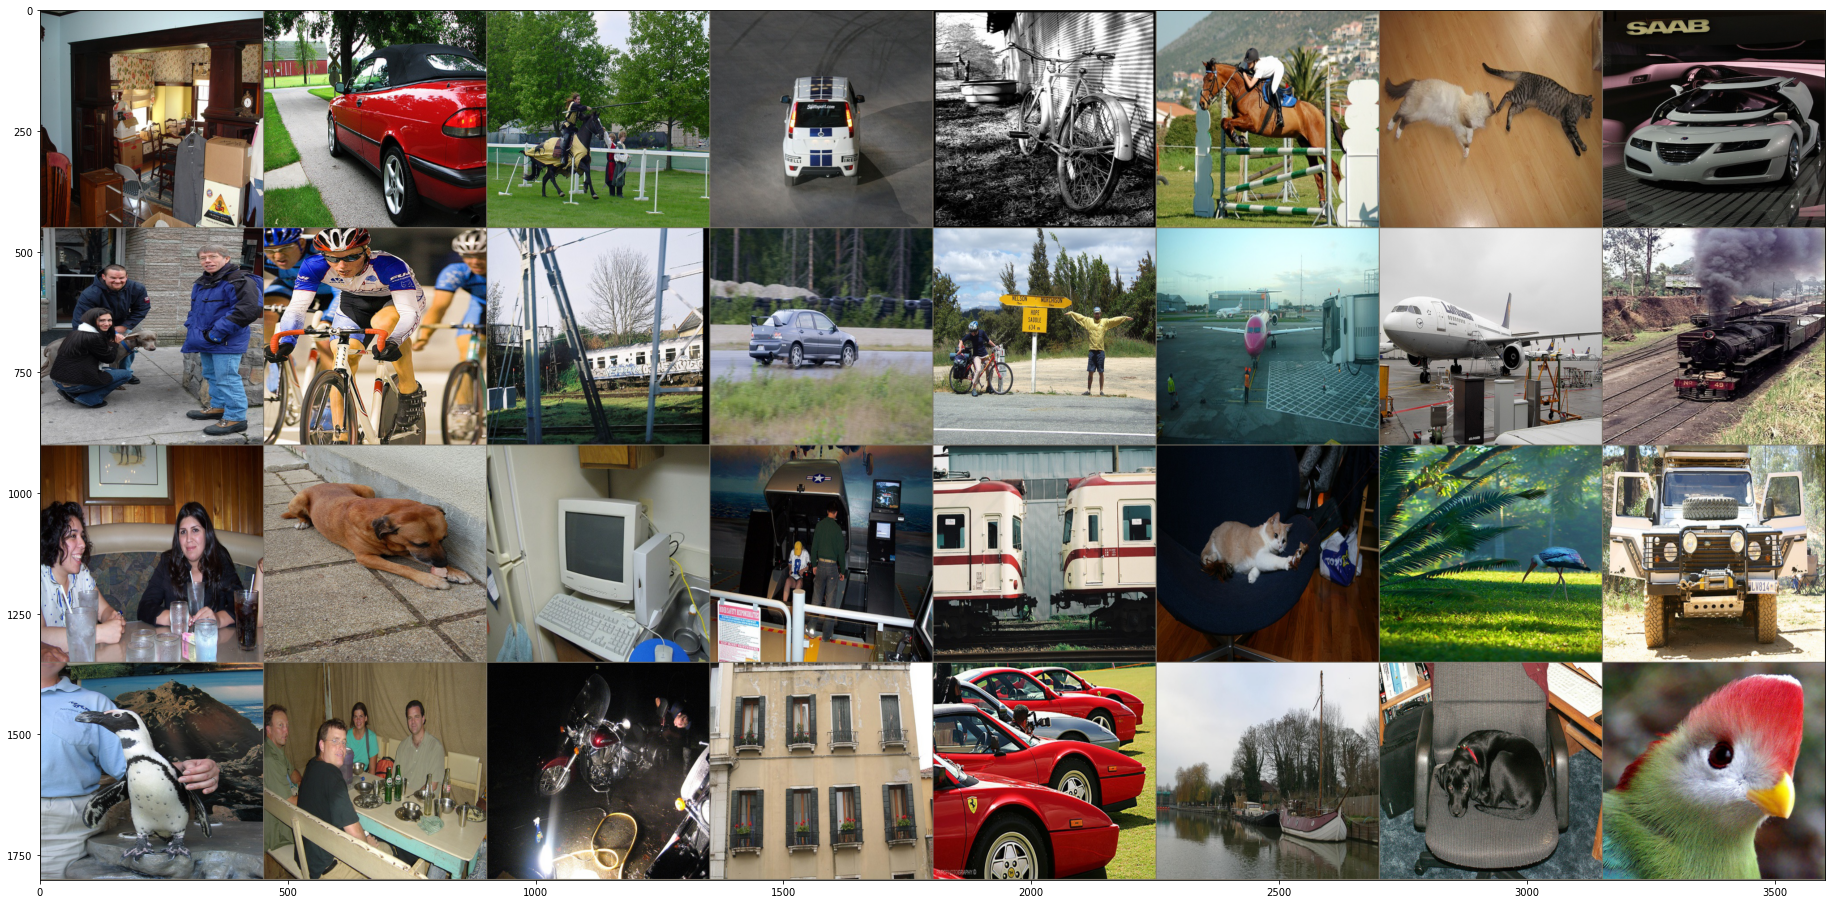

In [7]:
train_dl_predef, test_dl_predef = dataset.prepare_data(config["batch_size"], config["include_difficult"], config["transforms"], config["train_years"], num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


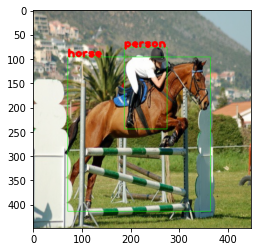

In [8]:
image, labels, _ = iter(train_dl_predef).next()
utils.show_image_with_classes_(image[5], labels[5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


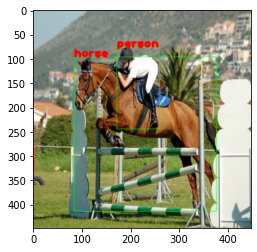

In [56]:
image, labels, _ = iter(train_dl_predef).next()
utils.show_image_with_classes_(image[5], labels[5])

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [6]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
objects_dist = np.zeros(20)
images_dist = np.zeros(20)

In [10]:
for _, labels, _ in train_dl_predef:
    for object_array in labels:
        classes_array = np.zeros(20)
        for box in object_array:
            class_category = int(box[4])
            objects_dist[class_category] += 1
            
            if classes_array[class_category] != 1:
                classes_array[class_category] = 1
        images_dist += classes_array

In [11]:
objects_dist

array([13256.,  1605.,  1593.,   847.,  2025.,  1072.,  1070.,  1171.,
        1064.,  1140.,   822.,  3267.,  1052.,   925.,  1764.,  3152.,
           0.,     0.,   814.,  1108.])

In [12]:
images_dist

array([6095., 1095., 1417.,  444., 1707.,  769.,  421.,  908.,  795.,
        689.,  607., 1874.,  771.,  805.,  950., 1564.,    0.,    0.,
        736.,  831.])

In [19]:
classes_dict = {'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 'horse': 5, 'sheep': 6, 'aeroplane': 7,
                'bicycle': 8, 'boat': 9, 'bus': 10, 'car': 11, 'motorbike': 12, 'train': 13, 'bottle': 14,
                'chair': 15, 'diningtable': 16, 'pottedplant': 17, 'sofa': 18, 'tvmonitor': 19}
inverse_classes_dict = {v: k for k, v in classes_dict.items()}

In [14]:
objects_dist_df = pd.DataFrame(np.concatenate((objects_dist.reshape(-1,1), images_dist.reshape(-1,1)), axis=1), columns=["Liczba obiektów", "Liczba zdjęć z obiektem"]).reset_index()
objects_dist_df = objects_dist_df.rename({'index': 'Klasa obiektu'}, axis='columns')
objects_dist_df = objects_dist_df.replace({"Klasa obiektu": inverse_classes_dict})
objects_dist_df

Klasa obiektu  Liczba obiektów  Liczba zdjęć z obiektem
0         person          13256.0                   6095.0
1           bird           1605.0                   1095.0
2            cat           1593.0                   1417.0
3            cow            847.0                    444.0
4            dog           2025.0                   1707.0
5          horse           1072.0                    769.0
6          sheep           1070.0                    421.0
7      aeroplane           1171.0                    908.0
8        bicycle           1064.0                    795.0
9           boat           1140.0                    689.0
10           bus            822.0                    607.0
11           car           3267.0                   1874.0
12     motorbike           1052.0                    771.0
13         train            925.0                    805.0
14        bottle           1764.0                    950.0
15         chair           3152.0                   1564.0
16   diningtable              0.0                      0.0
17   pottedplant              0.0                      0.0
18          sofa            814.0                    736.0
19     tvmonitor           1108.0                    831.0

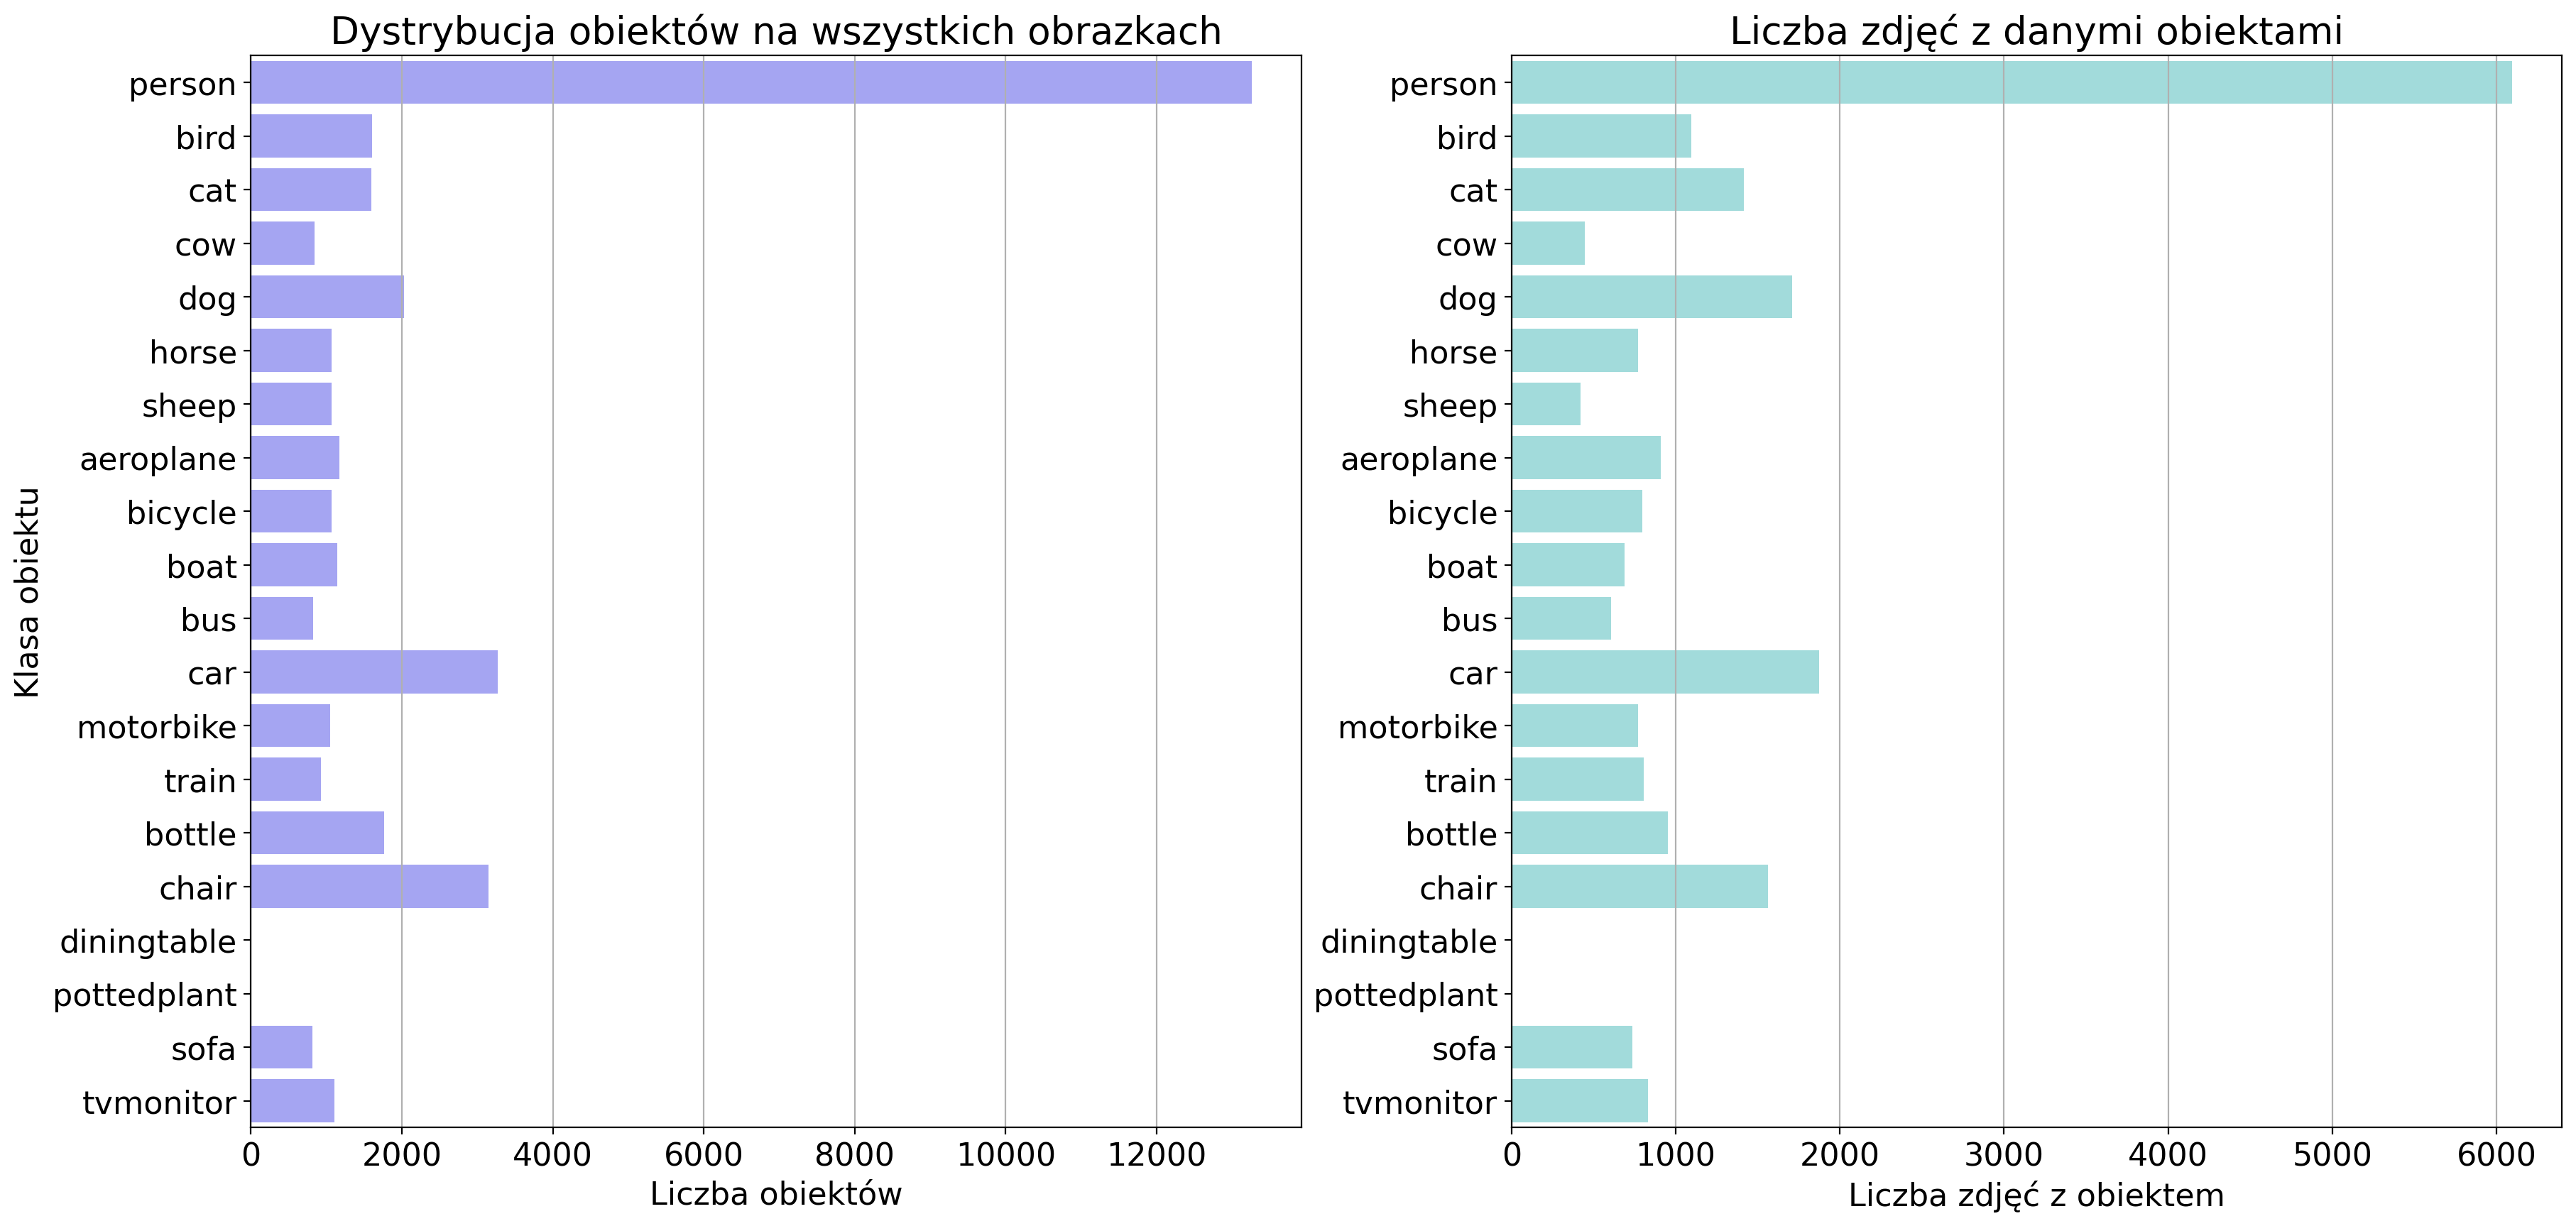

In [15]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(21, 10), dpi=200)
# fig, ax = plt.subplots(nrows=1, ncols=2)

plt.subplot(1, 2, 1)
sns.barplot(x="Liczba obiektów", y="Klasa obiektu", color='b', data=objects_dist_df, alpha=0.4)
plt.title("Dystrybucja obiektów na wszystkich obrazkach")
plt.grid(axis='x')

plt.subplot(1, 2, 2)
ax = sns.barplot(x="Liczba zdjęć z obiektem", y="Klasa obiektu", color='c', data=objects_dist_df, alpha=0.4)
ax.set(ylabel=None)
plt.title("Liczba zdjęć z danymi obiektami")
plt.grid(axis='x')

plt.savefig("Bledna_dystrybucja_2.png")
plt.show()


### Data augmentation

In [100]:
importlib.reload(dataset)

<module 'dataset' from 'C:\\OneDrive\\OneDrive - Politechnika Warszawska\\0.inzynierka_windows\\YOLO-recreated\\dataset.py'>

In [101]:
sample = dataset.VOCDataset(2007, "train", include_difficult=False, transforms=False)

Using downloaded and verified file: ./data\VOCtrainval_06-Nov-2007.tar
Extracting ./data\VOCtrainval_06-Nov-2007.tar to ./data


In [106]:
FONT = cv2.FONT_HERSHEY_PLAIN
green = (0, 255, 0)
red = (255, 0, 0)
thickness = 1
font_size = 1.5
S = 7

def show_image_with_classes_(image, labels):
    # un_norm = dataset.DeNormalize(dataset.MEAN, dataset.STD)
    # # denormalize the image
    # npimg = un_norm(image.clone()).numpy()
    npimg = image.transpose((1, 2, 0)).copy()

    for bbox in labels:
        x = int(bbox[0])
        y = int(bbox[1])
        x2 = int(bbox[2])
        y2 = int(bbox[3])
        class_name = inverse_classes_dict[int(bbox[4])]

        cv2.rectangle(npimg, (x, y), (x2, y2), green, thickness)
        cv2.putText(npimg, class_name, (x, y), FONT, font_size, red, thickness + 2)

    # Display the image
    plt.imshow(npimg)

In [107]:
_, labels = sample[1]

error: OpenCV(4.5.3) C:\Users\runneradmin\AppData\Local\Temp\pip-req-build-q3d_8t8e\opencv\modules\core\src\copy.cpp:71: error: (-215:Assertion failed) cn <= 4 in function 'cv::scalarToRawData'


In [108]:
labels

array([[185.,  62., 279., 199.,   0.],
       [ 90.,  78., 403., 336.,   5.]])

In [122]:
importlib.reload(utils)

<module 'utils' from 'C:\\OneDrive\\OneDrive - Politechnika Warszawska\\0.inzynierka_windows\\YOLO-recreated\\utils.py'>

In [79]:
import albumentations as A
import cv2 
from PIL import Image
from albumentations.pytorch import ToTensorV2

In [109]:
image = Image.open("./transformations/000017.jpg")

In [81]:
SIZE = 448, 448
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
classes_dict = {'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 'horse': 5, 'sheep': 6, 'aeroplane': 7,
                'bicycle': 8, 'boat': 9, 'bus': 10, 'car': 11, 'motorbike': 12, 'train': 13, 'bottle': 14,
                'chair': 15, 'diningtable': 16, 'pottedplant': 17, 'sofa': 18, 'tvmonitor': 19}
inverse_classes_dict = {v: k for k, v in classes_dict.items()}

In [93]:
labels[:, :4] = labels[:, :4] / 448

In [91]:
labels

array([[0.38541667, 0.17032967, 0.58125   , 0.5467033 ],
       [0.1875    , 0.21428571, 0.83958333, 0.92307692]])

In [341]:
transform = A.Compose([
    A.Resize(height=SIZE[1], width=SIZE[0], always_apply=True),
    # A.RandomCrop(width=380, height=380, p=1.0),
    # A.Resize(height=SIZE[1], width=SIZE[0], always_apply=True),
    # A.VerticalFlip(p=1.0),
    # A.Sharpen(p=1.0),
    # A.RandomSunFlare(p=1.0),
    # A.RandomFog(p=1.0),
    # A.RandomRain(p=1.0),
    # A.augmentations.transforms.Cutout(p=1.0),
    # A.Blur(blur_limit=3, p=1.0),
    # A.OneOf([
    #     A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
    #     A.ColorJitter(p=0.5),
    # ], p=1.0),
    # A.Rotate(limit=15, p=1.0, border_mode=cv2.BORDER_REFLECT_101),
    A.MaskDropout(p=1.0),
    A.Normalize(mean=MEAN, std=STD),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5))

In [330]:
transform = A.Compose([
            A.Resize(height=SIZE[1], width=SIZE[0], always_apply=True),
            A.Compose([
                    A.RandomCrop(width=380, height=380, p=1.0),
                    A.Resize(height=SIZE[1], width=SIZE[0], always_apply=True)
            ], p=0.05),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.01),
            A.Blur(blur_limit=3, p=0.5),
            A.OneOf([
                A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
                A.ColorJitter(p=0.4),
            ], p=1.0),
            A.Rotate(limit=10, p=0.2, border_mode=cv2.BORDER_REFLECT_101),
            A.augmentations.transforms.Cutout(num_holes=4, max_h_size=3, max_w_size=3, p=0.1),
            A.Normalize(mean=MEAN, std=STD),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5))

In [342]:
transformed = transform(image=np.array(image), bboxes=labels)
img, bboxes = transformed["image"], transformed["bboxes"]

AssertionError: MaskDropout requires ['mask']

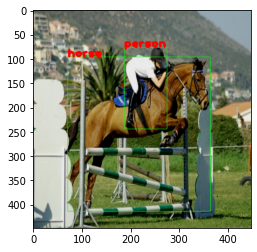

In [337]:
utils.show_image_with_classes_(img, bboxes, False, "./transformations/sample.png")

In [113]:
labels

array([[185.,  62., 279., 199.,   0.],
       [ 90.,  78., 403., 336.,   5.]])

### sprawdzenie zbioru testowego

In [7]:
test_dl = dataset.prepare_test_data(config["batch_size"], config["include_difficult"])

Using downloaded and verified file: ./data\VOCtest_06-Nov-2007.tar
Extracting ./data\VOCtest_06-Nov-2007.tar to ./data


In [23]:
boxes_areas = [[] for _ in range(20)]

for _, labels, _ in test_dl:
    for object_array in labels:
        for box in object_array:
            class_category = int(box[4])
            box_area = (box[3] - box[1]) * (box[2] - box[0]) / 448**2
            boxes_areas[class_category].append(box_area)

In [40]:
np_areas = np.array([np.array([sum(areas) / len(areas), np.array(areas).std()]) for areas in boxes_areas])

In [41]:
np_areas

array([[0.16380012, 0.19676069],
       [0.1979602 , 0.2290904 ],
       [0.42105457, 0.27465561],
       [0.17071787, 0.22688342],
       [0.35907718, 0.25938452],
       [0.30887968, 0.21763316],
       [0.12827335, 0.17511221],
       [0.24485332, 0.25787094],
       [0.24452511, 0.24851883],
       [0.18160016, 0.22092818],
       [0.30796025, 0.26006558],
       [0.2118041 , 0.26056897],
       [0.27415395, 0.260468  ],
       [0.36036838, 0.26318789],
       [0.05594385, 0.09461364],
       [0.12552532, 0.17536365],
       [0.35334872, 0.25603398],
       [0.11759254, 0.17202896],
       [0.36312381, 0.25131297],
       [0.1278591 , 0.16600977]])

In [42]:
objects_dist_df = pd.DataFrame(np_areas, columns=["Średnie pole ramek dla obiektów", "Odchylenie standardowe"]).reset_index()
objects_dist_df = objects_dist_df.rename({'index': 'Klasa obiektu'}, axis='columns')
objects_dist_df = objects_dist_df.replace({"Klasa obiektu": inverse_classes_dict})
objects_dist_df = objects_dist_df.sort_values("Średnie pole ramek dla obiektów", ascending=True)
objects_dist_df

Klasa obiektu  Średnie pole ramek dla obiektów  Odchylenie standardowe
14        bottle                         0.055944                0.094614
17   pottedplant                         0.117593                0.172029
15         chair                         0.125525                0.175364
19     tvmonitor                         0.127859                0.166010
6          sheep                         0.128273                0.175112
0         person                         0.163800                0.196761
3            cow                         0.170718                0.226883
9           boat                         0.181600                0.220928
1           bird                         0.197960                0.229090
11           car                         0.211804                0.260569
8        bicycle                         0.244525                0.248519
7      aeroplane                         0.244853                0.257871
12     motorbike                         0.274154                0.260468
10           bus                         0.307960                0.260066
5          horse                         0.308880                0.217633
16   diningtable                         0.353349                0.256034
4            dog                         0.359077                0.259385
13         train                         0.360368                0.263188
18          sofa                         0.363124                0.251313
2            cat                         0.421055                0.274656

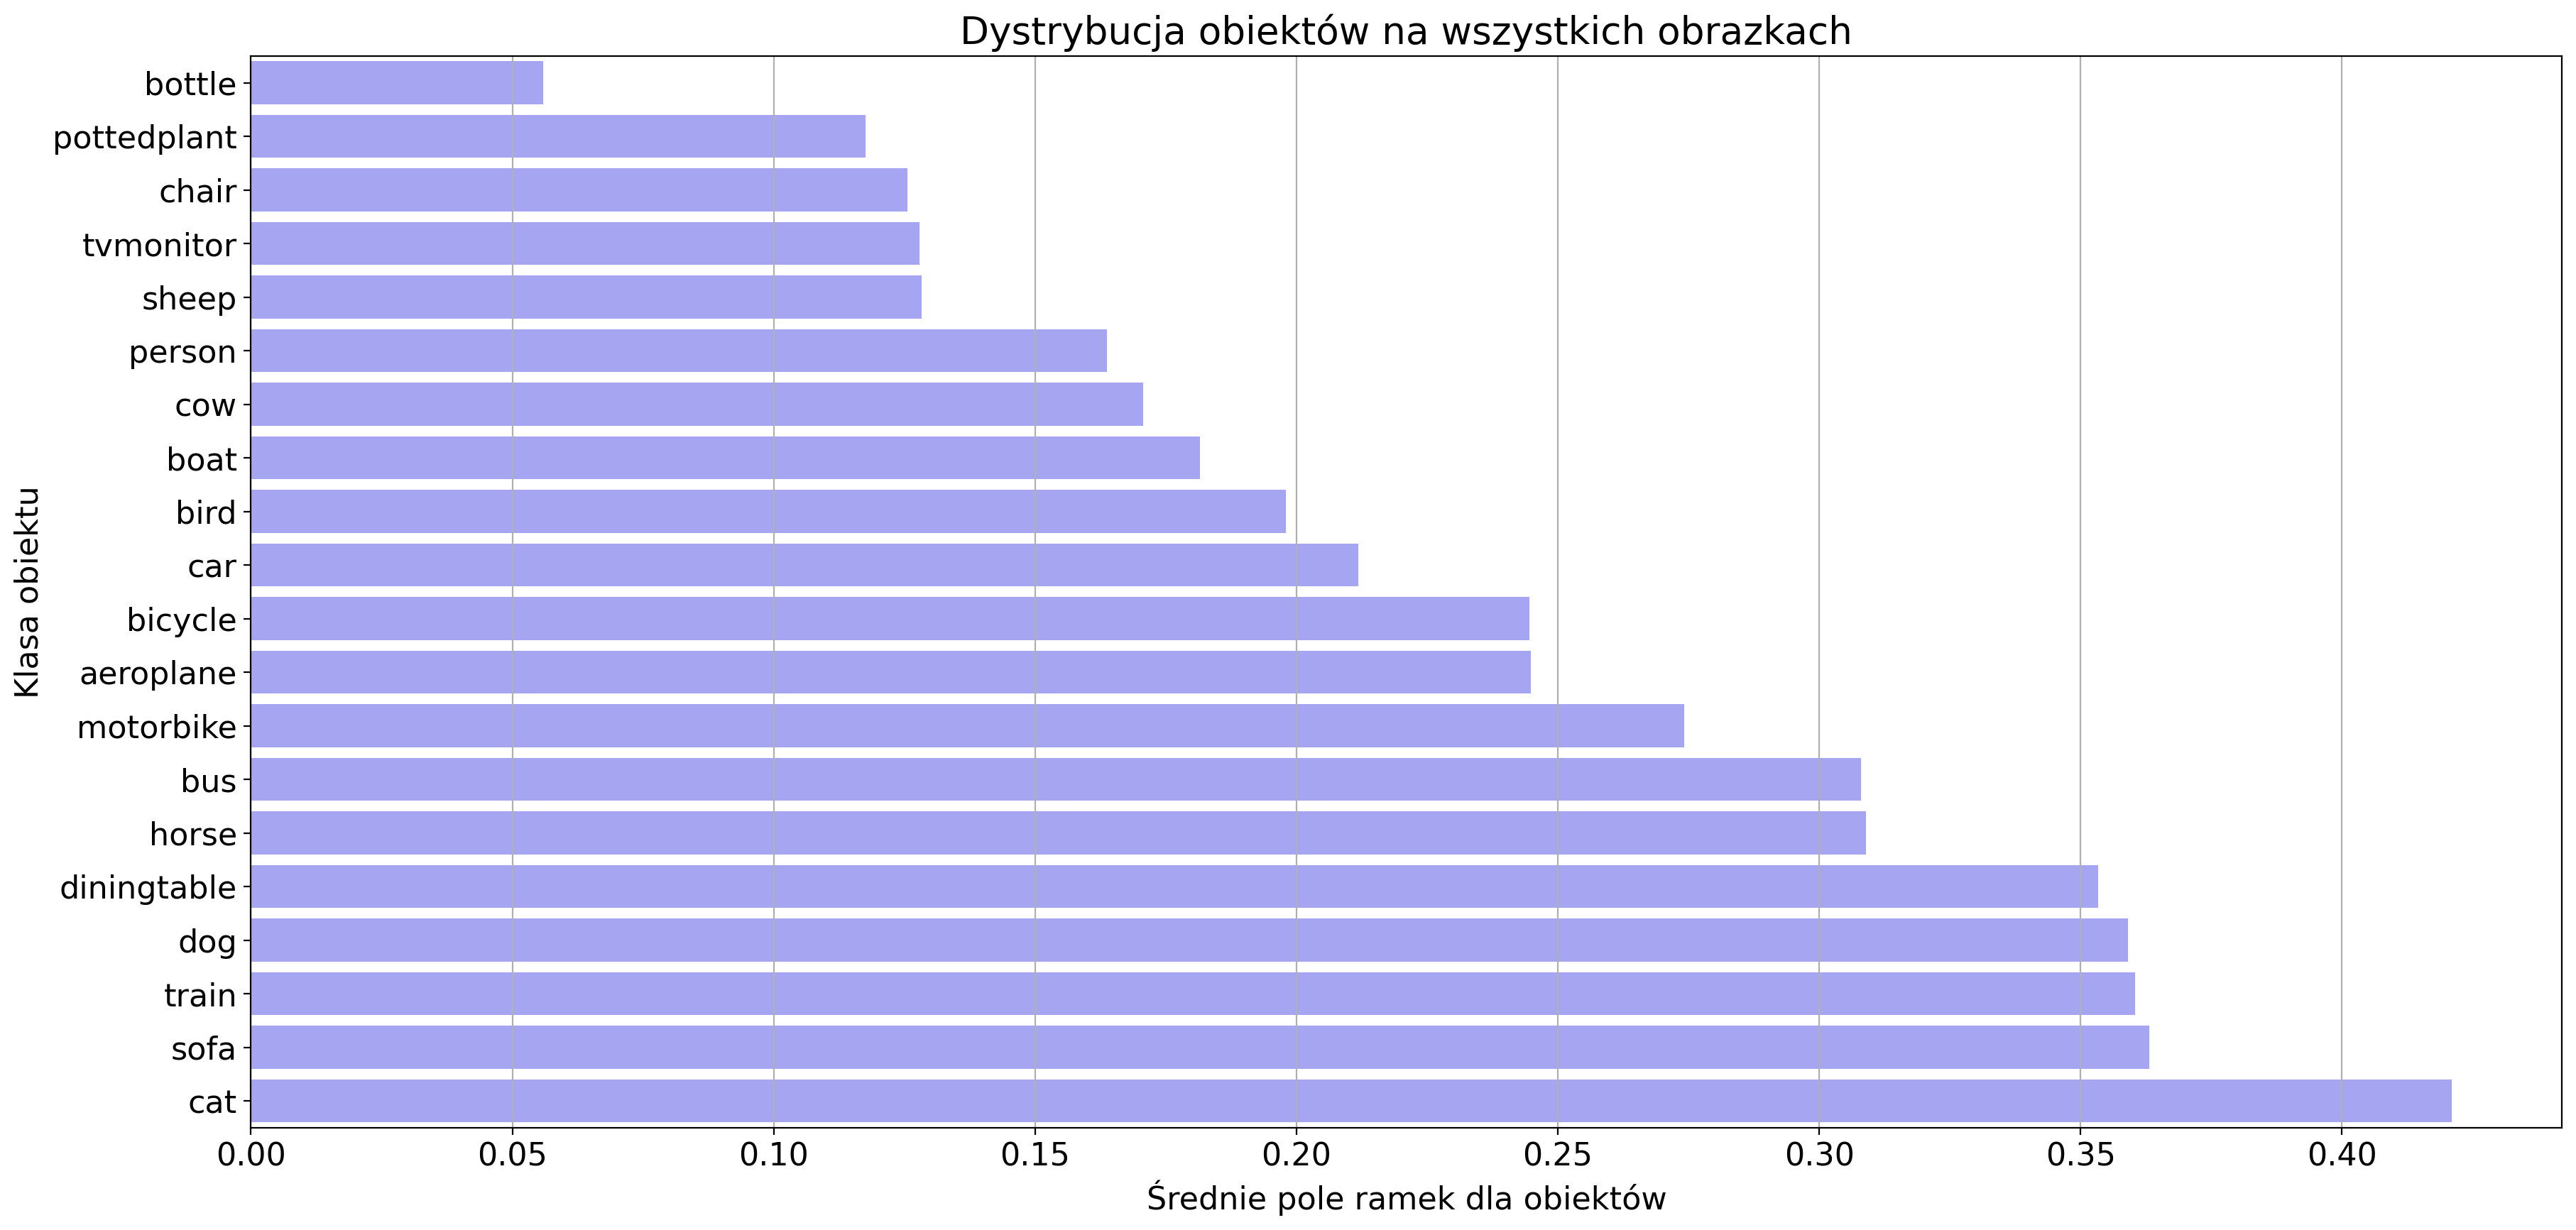

In [50]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(21, 10), dpi=200)
# fig, ax = plt.subplots(nrows=1, ncols=2)

# plt.subplot(1, 2, 1)
ax = sns.barplot(x="Średnie pole ramek dla obiektów", y="Klasa obiektu", color='b', data=objects_dist_df, alpha=0.4)
# ax.errorbar(data=objects_dist_df, x='Średnie pole ramek dla obiektów', y='Klasa obiektu', yerr='Odchylenie standardowe', ls='', lw=3, color='black')
plt.title("Dystrybucja obiektów na wszystkich obrazkach")
plt.grid(axis='x')

# plt.subplot(1, 2, 2)
# ax = sns.barplot(x="Liczba zdjęć z obiektem", y="Klasa obiektu", color='c', data=objects_dist_df, alpha=0.4)
# ax.set(ylabel=None)
# plt.title("Liczba zdjęć z danymi obiektami")
# plt.grid(axis='x')

# plt.savefig("Bledna_dystrybucja_2.png")
plt.show()

In [55]:
pd_areas = pd.DataFrame([])

for i, areas in enumerate(boxes_areas):
    data = [[inverse_classes_dict[i], area] for area in areas]
    temp = pd.DataFrame(data, columns=["Klasa obiektu", "Pole ramki"])
    pd_areas = pd.concat([pd_areas, temp], ignore_index=True)
    
pd_areas

Klasa obiektu  Pole ramki
0            person    0.947218
1            person    0.139736
2            person    0.010270
3            person    0.010270
4            person    0.014006
...             ...         ...
12027     tvmonitor    0.096064
12028     tvmonitor    0.041472
12029     tvmonitor    0.038763
12030     tvmonitor    0.033227
12031     tvmonitor    0.062720

[12032 rows x 2 columns]

In [80]:
order = pd_areas.groupby("Klasa obiektu").agg("mean")
order = order.sort_values("Pole ramki", ascending=True)
order.index

Index(['bottle', 'pottedplant', 'chair', 'tvmonitor', 'sheep', 'person', 'cow',
       'boat', 'bird', 'car', 'bicycle', 'aeroplane', 'motorbike', 'bus',
       'horse', 'diningtable', 'dog', 'train', 'sofa', 'cat'],
      dtype='object', name='Klasa obiektu')

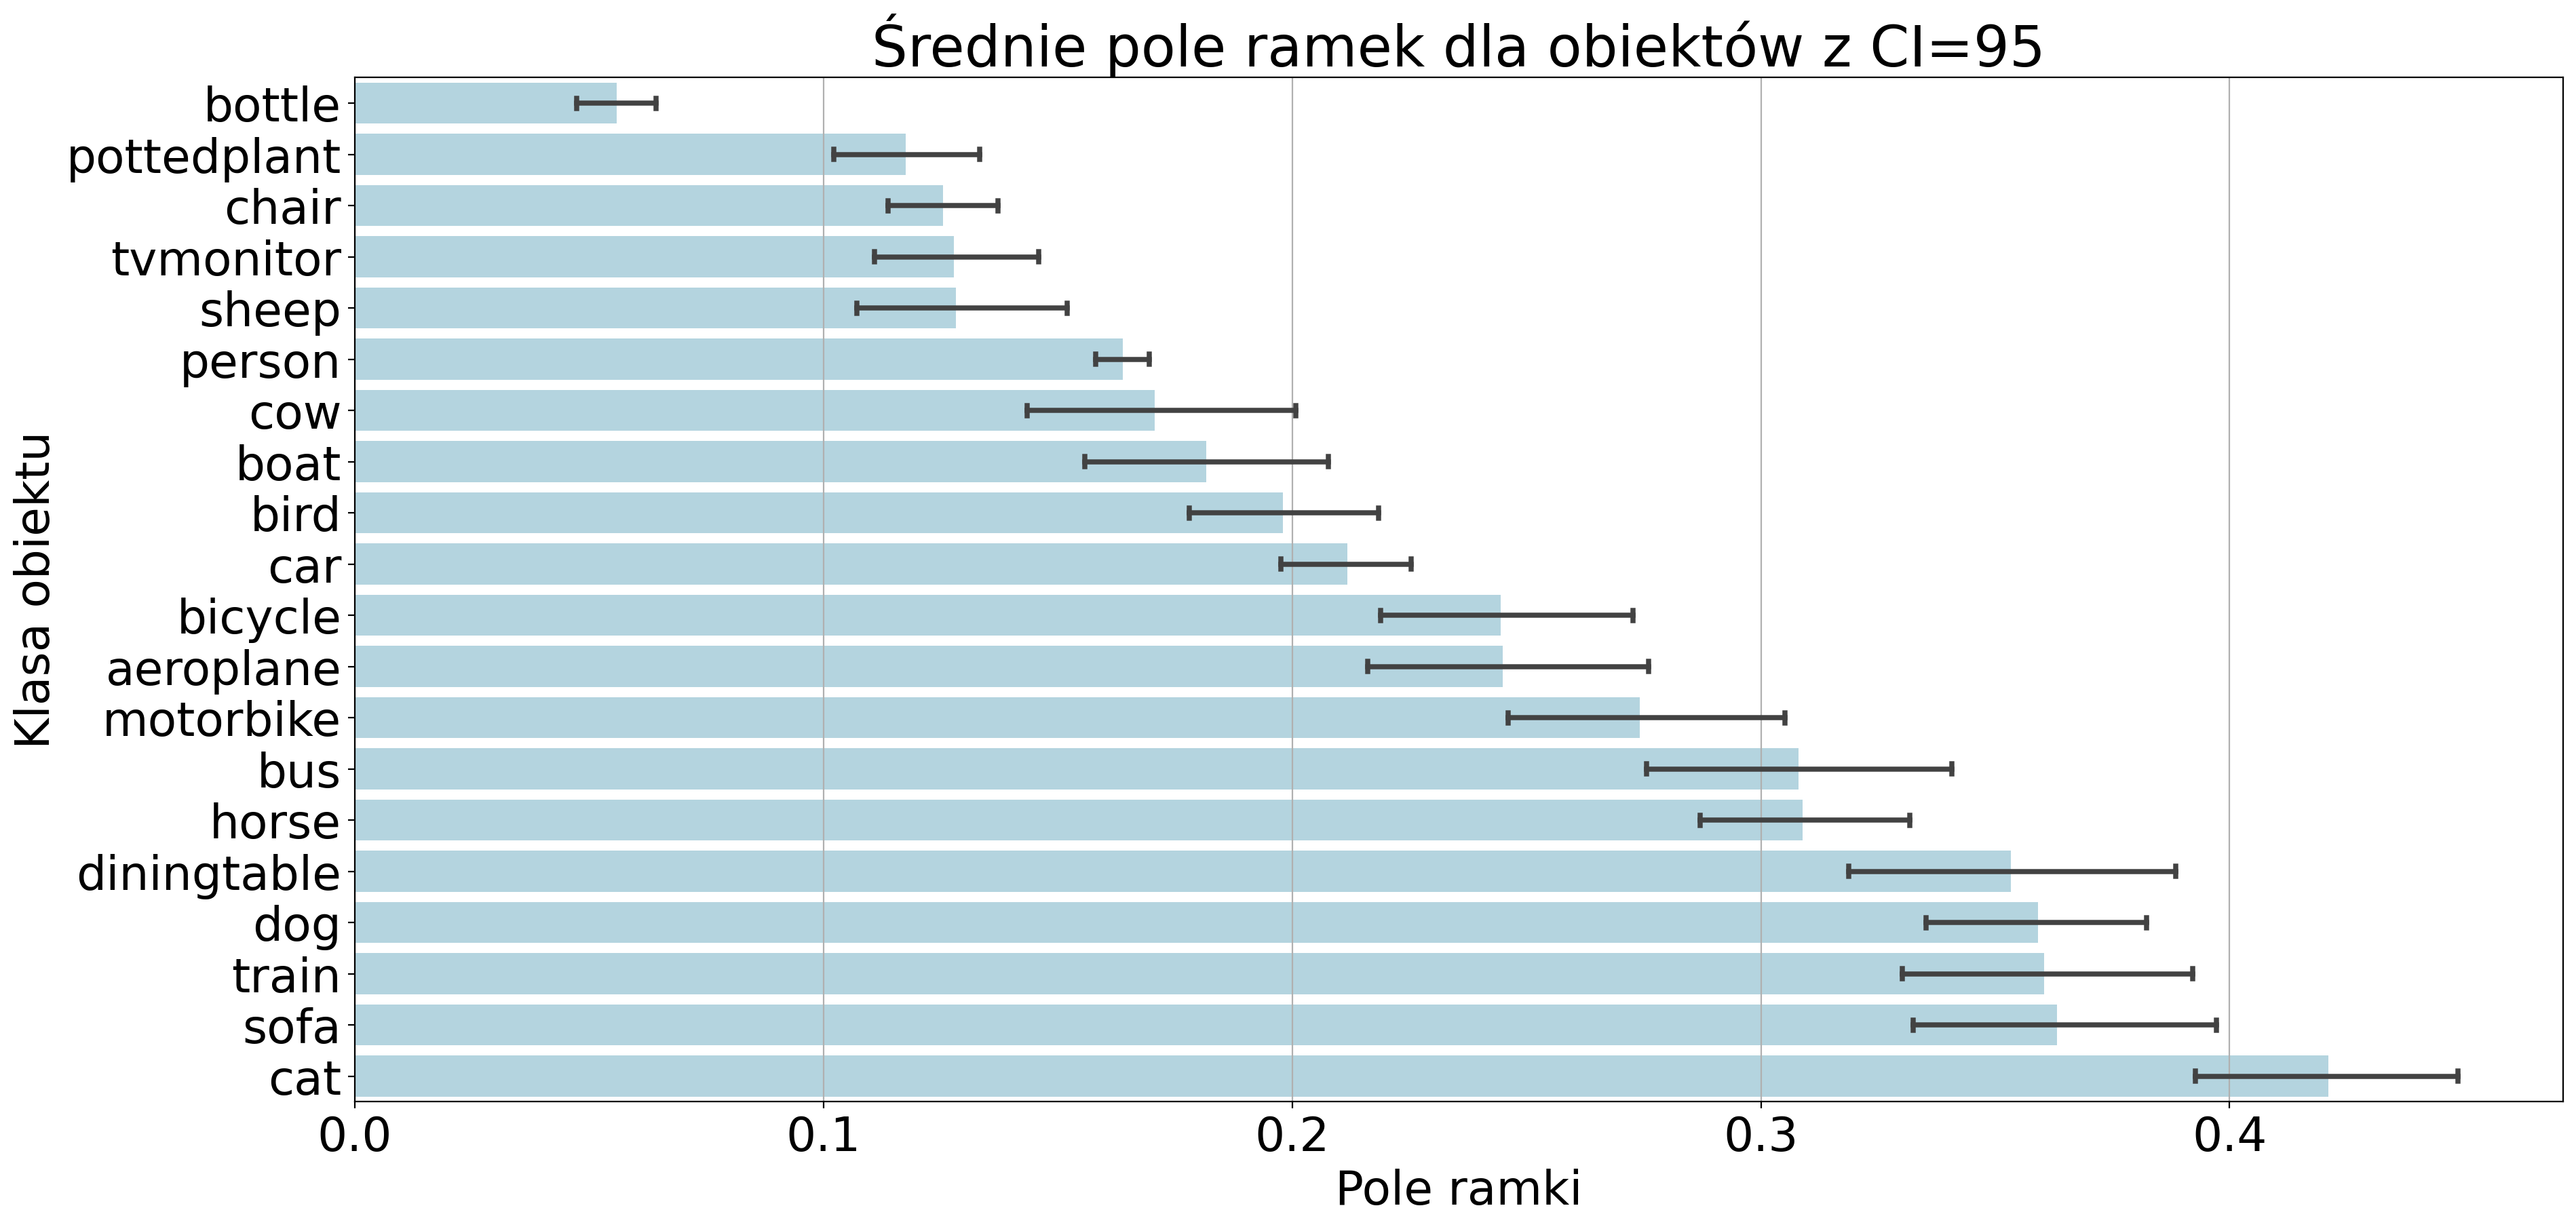

In [83]:
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(21, 10), dpi=200)
# fig, ax = plt.subplots(nrows=1, ncols=2)

ax = sns.barplot(x="Pole ramki", y="Klasa obiektu", data=pd_areas, estimator=np.mean, ci=95, capsize=.2, color='lightblue', order=order.index)
plt.title("Średnie pole ramek dla obiektów z CI=95")
plt.grid(axis='x')

plt.savefig("pola_ramek.png")
plt.show()